# Neural Network for MNIST database recognizing

This is a Neural Network developed without Machine Learning frameworks, using `numpy` and `matplotlib`, only for learning purposes. The objective of this project is practice Neural Networks Design principles and enhance knowledges on Machine Learning and Deep Learning.


## 1 - Library imports

In [1607]:
import mnist
import numpy as np
import matplotlib.pyplot as plt
import os
from enum import Enum, unique
np.seterr(all='warn')

{'divide': 'warn', 'over': 'warn', 'under': 'warn', 'invalid': 'warn'}

## 2 - MNIST Datasets download

In [1608]:
if(not os.path.isdir("./datasets/")):
    os.mkdir("./datasets")
if(not os.path.isfile("./datasets/train-images-idx3-ubyte.gz")):
    mnist.download_file("train-images-idx3-ubyte.gz", "./datasets")
if(not os.path.isfile("./datasets/train-labels-idx1-ubyte.gz")):
    mnist.download_file("train-labels-idx1-ubyte.gz", "./datasets")
if(not os.path.isfile("./datasets/t10k-images-idx3-ubyte.gz")):
    mnist.download_file("t10k-images-idx3-ubyte.gz", "./datasets")
if(not os.path.isfile("./datasets/t10k-labels-idx1-ubyte.gz")):
    mnist.download_file("t10k-labels-idx1-ubyte.gz", "./datasets")

## 3 - MNIST Datasets Load

In [1609]:
train_images_raw = mnist.train_images()
train_labels_raw = mnist.train_labels()
test_images_raw = mnist.test_images()
test_labels_raw = mnist.test_labels()

train_images = np.transpose(train_images_raw.reshape(train_images_raw.shape[0], train_images_raw.shape[1]*train_images_raw.shape[2]))

train_labels = np.zeros((train_labels_raw.shape[0], train_labels_raw.max()+1))
train_labels[np.arange(train_labels_raw.shape[0]), train_labels_raw] = 1
train_labels = np.transpose(train_labels)

test_images = np.transpose(test_images_raw.reshape(test_images_raw.shape[0], test_images_raw.shape[1]*test_images_raw.shape[2]))

test_labels = np.zeros((test_labels_raw.shape[0], test_labels_raw.max()+1))
test_labels[np.arange(test_labels_raw.shape[0]), test_labels_raw] = 1
test_labels = np.transpose(test_labels)

print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(784, 60000) (10, 60000) (784, 10000) (10, 10000)


## 4 - Activation functions enum

In [1610]:
@unique
class Activation(Enum):
    SIGMOID = 1
    TANH = 2
    RELU = 3
    LEAKY_RELU = 4

## 5 - Hyperparameters

In [1611]:
FEATURES = train_images.shape[0]
LAYERS = 3
LAYER_UNITS = np.array([16, 10, 10], dtype=np.uint32)
LAYER_ACTIVATIONS = np.array([Activation['RELU'], Activation['TANH'], Activation['SIGMOID']])
ALPHA = 3*10e-2
LAMBDA_REG = 10e-7
ITERATIONS = 2000
EPSILON = 0.05

EXAMPLES = train_images.shape[1]

## 6 - Activation functions and it's derivatives

In [1612]:
LEAKY_RELU_MULTIPLIER = 0.01

def linear_func(X_matrix, W_matrix, b_array):
    return np.dot(W_matrix, X_matrix) + b_array

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def sigmoid_threshold(z):
    return np.round(z)

def tanh(z):
    return np.tanh(z)

def relu(z):
    return np.maximum(0, z)

def leaky_relu(z):
    return np.maximum(LEAKY_RELU_MULTIPLIER * z, z)

def derivative_sigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

def derivative_tanh(z):
    return 1 - (tanh(z)**2)

def derivative_relu(z):
    if(z < 0):
        return 0
    else:
        return 1

def derivative_leaky_relu(z):
    if(z < 0):
        return LEAKY_RELU_MULTIPLIER
    else:
        return 1

derivative_relu = np.vectorize(derivative_relu)
derivative_leaky_relu = np.vectorize(derivative_leaky_relu)

## 7 - Normalization functions

In [1613]:
def normalize_dataset(X_matrix):
    X_norm = np.zeros(X_matrix.shape)
    for i in range(X_matrix.shape[0]):
        X_norm[i] = X_matrix[i]/np.maximum(1, np.max(X_matrix[i]))
    return X_norm

def normalize_input(x_input, X_matrix):
    x_norm = np.zeros(x_input.shape)
    x_norm = x_input/np.maximum(1, np.max(X_matrix))
    return x_norm

## 8 - Forward and Backward Propagation Functions

In [1614]:
def fwd_prop(A_previous, W_layer, b_layer, activationType = Activation['SIGMOID']):
    Z_layer = linear_func(A_previous, W_layer, b_layer)
    if (activationType == Activation['SIGMOID']):
        A_layer = sigmoid(Z_layer)
    elif (activationType == Activation['TANH']):
        A_layer = tanh(Z_layer)
    elif (activationType == Activation['RELU']):
        A_layer = relu(Z_layer)
    elif (activationType == Activation['LEAKY_RELU']):
        A_layer = leaky_relu(Z_layer)
    else:
        A_layer = sigmoid(Z_layer)
    return A_layer, Z_layer

def back_prop(dA_layer, A_previous, Z_layer, W_layer, b_layer, activationType = Activation['SIGMOID']):
    if (activationType == Activation['SIGMOID']):
        dZ_layer = np.multiply(dA_layer, derivative_sigmoid(Z_layer))
    elif (activationType == Activation['TANH']):
        dZ_layer = np.multiply(dA_layer, derivative_tanh(Z_layer))
    elif (activationType == Activation['RELU']):
        dZ_layer = np.multiply(dA_layer, derivative_relu(Z_layer))
    elif (activationType == Activation['LEAKY_RELU']):
        dZ_layer = np.multiply(dA_layer, derivative_leaky_relu(Z_layer))
    else:
        dZ_layer = np.multiply(dA_layer, derivative_sigmoid(Z_layer))
    
    dW_layer = np.dot(dZ_layer, np.transpose(A_previous))/dZ_layer.shape[1]
    db_layer = np.sum(dZ_layer, axis = 1, keepdims = True)/dZ_layer.shape[1]
    dA_previous = np.dot(np.transpose(W_layer), dZ_layer)

    return dA_previous, dW_layer, db_layer   

## 9 - Predict Function

In [1615]:
def predict(X, W, b,
            layers = LAYERS,
            layer_activations = LAYER_ACTIVATIONS):
    A = X
    for i in range(1, layers+1):
        A, z = fwd_prop(A, W[i], b[i], layer_activations[i-1])
    return A

## 10 - Cost function

In [1616]:
def cost(X, y, W, b, lambda_reg = LAMBDA_REG):
    y_prediction = predict(X, W, b)
    regularization = 0
    loss = (1/2)*((y_prediction - y)**2)
    for i in W:
        regularization += np.sum(i**2)
    cost = (np.sum(loss, axis = 1, keepdims=True)/y.shape[1]) + ((lambda_reg/(2*y.shape[1]))*regularization)
    return cost

## 11 - Fit Function

In [1617]:
def fit(X, y,
        W_previous = None,
        b_previous = None,
        features = FEATURES,
        layers = LAYERS,
        layer_units = LAYER_UNITS,
        layer_activations = LAYER_ACTIVATIONS,
        examples = EXAMPLES,
        alpha = ALPHA,
        lambda_reg = LAMBDA_REG,
        iterations = ITERATIONS,
        epsilon = EPSILON):
    
    W = {1: np.random.randn(layer_units[0], features) * np.sqrt(2/features)}
    dW = {1: np.zeros([layer_units[0], features])}
    b = {1:np.random.randn(layer_units[0], 1)}
    db = {1: np.zeros([layer_units[0], 1])}
    Z = {0: X}
    A = {0: X}
    dA = {0: np.array([])}
    for k in range(layers - 1):
        W[k+2] = np.random.randn(layer_units[k+1], layer_units[k]) * np.sqrt(1/layer_units[k])
        dW[k+2] = np.zeros([layer_units[k+1], layer_units[k]])
        b[k+2] = np.random.randn(layer_units[k+1], 1)
        db[k+2] = np.zeros([layer_units[k+1], 1])
        Z[k+1] = np.zeros([layer_units[k+1], examples])
        A[k+1] = np.zeros([layer_units[k+1], examples])
        dA[k+1] = np.zeros([layer_units[k+1], examples])

    if(W_previous != None and b_previous != None):
        W = W_previous
        b = b_previous

    cost_points = []

    for i in range(iterations):

        for j in range(layers):
            A[j+1], Z[j+1] = fwd_prop(A[j], W[j+1], b[j+1], layer_activations[j])

        dA[layers] = - (y/A[layers]) + ((1-y)/(1-A[layers]))

        for j in range(layers-1, -1, -1):
            dA[j], dW[j+1], db[j+1] = back_prop(dA[j+1], A[j], Z[j+1], W[j+1], b[j+1], layer_activations[j])
        
        for j in range(1, layers+1):
            W[j] = (W[j] * (1 - ((alpha*lambda_reg)/y.shape[1]))) - (alpha*dW[j])
            b[j] = b[j] - (alpha*db[j])
  
        cost_points.append(cost(X, y, W, b))
        
        #print(np.transpose(cost_points[len(cost_points) - 1]))

    return W, b

## 12 - Training the N.N.

In [1618]:
train_images_normalized = normalize_dataset(train_images)
W_final, b_final = fit(train_images_normalized, train_labels)

[[0.04462691 0.06372766 0.04542018 0.05504712 0.08055617 0.17995309
  0.04488528 0.04727036 0.04703214 0.05757741]]
[[0.04457407 0.05174811 0.0452648  0.04880501 0.04937058 0.05376636
  0.04474994 0.04700164 0.04497308 0.04786001]]
[[0.04456318 0.04959859 0.04511461 0.04709239 0.04545253 0.04437889
  0.0446363  0.04686804 0.04433593 0.04582097]]
[[0.04455807 0.04898993 0.04497764 0.04657303 0.04448793 0.04232557
  0.04457075 0.04680277 0.04406042 0.04514918]]
[[0.0445578  0.04875336 0.04486882 0.0463716  0.04415721 0.04165512
  0.04453382 0.04676771 0.04393254 0.04488537]]
[[0.04456097 0.04862249 0.04478268 0.04628207 0.04402343 0.04139169
  0.04451071 0.04674808 0.04386488 0.04476744]]
[[0.04456709 0.04851714 0.04470767 0.04623842 0.04396264 0.04127943
  0.04449359 0.04673615 0.04382165 0.04470712]]
[[0.04457631 0.04840806 0.04462842 0.04621542 0.04393121 0.04123351
  0.04447826 0.04672727 0.04378643 0.04466954]]
[[0.04458946 0.0482808  0.04452221 0.04620181 0.04391125 0.04122333
  0.

## 13 - Saving Checkpoint

In [1619]:
W_save = W_final
b_save = b_final

In [1762]:
if(not os.path.isdir("./training-checkpoint/")):
    os.mkdir("./training-checkpoint/")

#checkpoint_file = open("./training-checkpoint/checkpoint.txt", 'w')
for i in W_save:
    np.savetxt(f'./training-checkpoint/w{i}.csv', W_save[i], delimiter=',')
for i in b_save:
    np.savetxt(f'./training-checkpoint/b{i}.csv', b_save[i], delimiter=',')
#checkpoint_file.close()

## 14 - Loading Checkpoint

In [1763]:
for i in range(1, LAYERS + 1):
    W_save[i] = np.loadtxt(f'./training-checkpoint/w{i}.csv', delimiter=',')
    b_save[i] = np.loadtxt(f'./training-checkpoint/b{i}.csv', delimiter=',')

## 15 - Test playground

Saída esperada: 8
Saída predita: 8


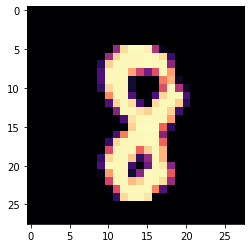

In [1754]:
index = int(np.round(np.random.rand()*len(test_images_raw)))

plt.imshow(test_images_raw[index], cmap='magma')
test_sample = normalize_input(test_images[:, index].reshape(test_images[:, index].shape[0], 1), test_images)
test_predict = sigmoid_threshold(np.transpose(predict(test_sample, W_save, b_save)))
print(f"Saída esperada: {test_labels_raw[index]}")
for i in range(len(test_predict[0])):
    if test_predict[0, i] == 1:
        print(f"Saída predita: {i}")
        break
    if(i == 9):
        print(f"Sem predição válida.")